In [106]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pygeohash as pgh

## Read file 


In [107]:
file_path = '1987-2016.kml'
# read file
ty_name=[]
intensity=[]
mslp=[]
max_int=[]
min_slp=[]
timesteps=[]
lon=[]
lat=[]
ty_data=np.ndarray(shape = (0,1))
z = np.zeros((0,1))
import lxml.etree as etree
import re
parser = etree.XMLParser(strip_cdata=False)
tree = etree.parse(file_path, parser=parser)
#print(etree.tostring(tree, xml_declaration=True))
#print(tree.xpath('//kml:Placemark/kml:TimeSpan/text()', namespaces={"kml":"http://www.opengis.net/kml/2.2"}))
nmsp = '{http://www.opengis.net/kml/2.2}'


## Data Cleansing

In [108]:
### walk through history typhoon file ###
for fd in tree.iterfind('/{0}Document/{0}Folder/{0}Folder/{0}Folder'.format(nmsp)):
    temp = fd.find('{0}Placemark/{0}name'.format(nmsp)).text
    ty_name.append(temp)
    count=0
    ## feature extraction ##
    for dscp in fd.iterfind('{0}Placemark'.format(nmsp)):
        #print(dscp.find('{0}description'.format(nmsp)).text)
        dscript = dscp.find('{0}description'.format(nmsp)).text
        dscript = re.split(r'<[^>]+>|[\s\n\t]', dscript)
        temp_info= np.array([ele for ele in dscript if len(ele)>0])
        #print(len(temp_info))
        if len(temp_info) == 26:
            temp_info=np.append(temp_info,count)
            timesteps=np.append(timesteps,count)
            intensity=np.append(intensity,[temp_info[13]])
            mslp=np.append(mslp,[temp_info[16]])
            max_int=np.append(max_int,[temp_info[20]])
            min_slp=np.append(min_slp,[temp_info[24]])
            count+=1
        elif len(temp_info) == 30:
            timesteps=np.append(timesteps,count)
            intensity=np.append(intensity,[temp_info[17]])
            mslp=np.append(mslp,[temp_info[20]])
            max_int=np.append(max_int,[temp_info[24]])
            min_slp=np.append(min_slp,[temp_info[28]])
            count+=1
        elif len(temp_info) == 33:
            timesteps=np.append(timesteps,count)
            intensity=np.append(intensity,[temp_info[17]])
            mslp=np.append(mslp,[temp_info[23]])
            max_int=np.append(max_int,[temp_info[27]])
            min_slp=np.append(min_slp,[temp_info[31]])
            count+=1
        elif len(temp_info) == 35:
            timesteps=np.append(timesteps,count)
            intensity=np.append(intensity,[temp_info[20]])
            mslp=np.append(mslp,[temp_info[25]])
            max_int=np.append(max_int,[temp_info[29]])
            min_slp=np.append(min_slp,[temp_info[33]])
            count+=1
    for i in range(count,105):
        timesteps=np.append(timesteps,[i], axis=0)
        intensity= np.append(intensity, [0], axis = 0)
        mslp= np.append(mslp, [0], axis = 0)
        max_int= np.append(max_int, [0], axis = 0)
        min_slp= np.append(min_slp, [0], axis = 0)
        count+=1
    

In [109]:
### Geogaphic coordinate feature extraction ###
lon=[]
lat=[]
for fd in tree.iterfind('/{0}Document/{0}Folder/{0}Folder/{0}Folder'.format(nmsp)):
    count=0
    for coor in fd.iterfind('{0}Placemark/{0}Point'.format(nmsp)):
        geocoor = coor.find('{0}coordinates'.format(nmsp)).text
        lontitude,latitude,_ = geocoor.split(',')
        lon = np.append(lon,lontitude)
        lat = np.append(lat,latitude)
        count+=1
    for i in range(count,105):
        lon = np.append(lon,lon[-1])
        lat = np.append(lat,lat[-1])
    #print(len(lon))


In [110]:
from sklearn.preprocessing import normalize, MinMaxScaler, StandardScaler

standard = StandardScaler(copy=True, with_mean=True, with_std=True)
minmax = MinMaxScaler(copy=True, feature_range=(0, 1))

'''scaler = scaler.fit_transform(df)
scaler = scaler.fit_transform(df)
scaled_X = scaler.transform(df['Intensity','MSLP','Max Intensity','Minimum SLP'])

inverted_X = scaler.inverse_transform(scaled_X)
#arr = arr.reshape(arr.shape[0], 1, arr.shape[1])

train_x = df
train_y = df'''
#mslp = mslp.reshape(-1,1)
#standard = standard.fit_transform(mslp)

'''plt.figure(figsize=(20,5))
plt.hist(standard)'''
len(lon),len(intensity),len(mslp)

(95340, 95340, 95340)

In [111]:
#  to pandas Dataframe
#data = {'Max Intensity':max_int,'Minimum SLP':min_slp}
data = {'lon':lon,'lat':lat,'Intensity':intensity,'MSLP':mslp,'Max Intensity':max_int,'Minimum SLP':min_slp}
df = pd.DataFrame(data=data)
df = df.apply(pd.to_numeric,downcast='float')
for i,ele in enumerate(df['lon']):
    gh = pgh.encode(df['lon'][i],df['lat'][i],precision=4)
    df.loc[i,'geohash'] = gh

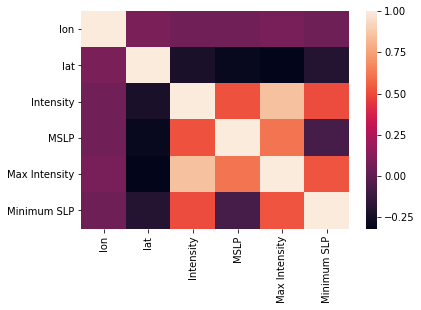

In [112]:
import seaborn as sns
data = df.corr()
sns.heatmap(data)

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from keras.models import load_model
%matplotlib inline

Using TensorFlow backend.


In [41]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:,:], train[:,:]
    X = train.reshape(96248, 1, train.shape[1])
    
    
    RMSprop = optimizers.RMSprop(lr=0.001, rho=0.9, decay=0.0, clipvalue=0.1)
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(7))
    model.compile(loss='mse', optimizer=RMSprop, metrics=['acc'])
    es = EarlyStopping(monitor='val_loss', patience=5)
    for i in range(0, 96248, 106):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False,validation_split=0.1,callbacks=[es])
        model.reset_states()
    model.save('lstm_RMSprop.h5')
    
    return model


In [44]:
%%time
fit_lstm(scaled_X, 1, 1, 4)

Train on 86623 samples, validate on 9625 samples
Epoch 1/1
86623/86623 [==============================] - 211s 2ms/step - loss: 0.2495 - acc: 0.8020 - val_loss: 0.1404 - val_acc: 0.7418
Train on 86623 samples, validate on 9625 samples
Epoch 1/1
86623/86623 [==============================] - 242s 3ms/step - loss: 0.2774 - acc: 0.8017 - val_loss: 0.1564 - val_acc: 0.7538
Train on 86623 samples, validate on 9625 samples
Epoch 1/1
86623/86623 [==============================] - 243s 3ms/step - loss: 0.2599 - acc: 0.7845 - val_loss: 0.1636 - val_acc: 0.7624
Train on 86623 samples, validate on 9625 samples
Epoch 1/1
86623/86623 [==============================] - 198s 2ms/step - loss: 0.2609 - acc: 0.7746 - val_loss: 0.2043 - val_acc: 0.6859
Train on 86623 samples, validate on 9625 samples
Epoch 1/1
86623/86623 [==============================] - 192s 2ms/step - loss: 0.2718 - acc: 0.7530 - val_loss: 0.2054 - val_acc: 0.7116
Train on 86623 samples, validate on 9625 samples
Epoch 1/1
86623/86623

KeyboardInterrupt: 

In [ ]:
model = load_model('lstm_RMSprop.h5')
train_reshaped = scaled_X.reshape(1800, 1, 11)
a = model.predict(train_reshaped, batch_size=1)
inversed_X = scaler.inverse_transform(a)

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(inversed_X[:,0])
plt.plot(arr[:,0])
plt.xlim([0,900])
plt.show()

In [ ]:
# returns train, inference_encoder and inference_decoder models
def define_models(n_input, n_output, n_units):
    # define training encoder
    encoder_inputs = Input(shape=(None, n_input))
    encoder = LSTM(n_units, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]
    # define training decoder
    decoder_inputs = Input(shape=(None, n_output))
    decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(n_output, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    # define inference encoder
    encoder_model = Model(encoder_inputs, encoder_states)
    # define inference decoder
    decoder_state_input_h = Input(shape=(n_units,))
    decoder_state_input_c = Input(shape=(n_units,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
    # return all models
    return model, encoder_model, decoder_model

def fit_seq2seq(train, batch_size, nb_epoch, neurons):
    X, y = train[:,:], train[:,:]
    X = train.reshape(train.shape[0], 1, train.shape[1])
    y = train.reshape(train.shape[0], 1, train.shape[1])
        
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True, return_sequences=True))
    model.add(Dense(11, activation="relu"))
    model.add(LSTM(11, return_sequences=True))
    model.add(TimeDistributed(Dense(units=11, 
                                    activation="softmax")))
    model.compile(loss='mae', optimizer='adam', metrics=['acc'])
    es = EarlyStopping(monitor='val_loss', patience=5)
    for i in range(0, 1800, 60):
        model.fit(X, y, epochs=100, batch_size=batch_size, verbose=1, shuffle=False,validation_split=0.1,callbacks=[es])
        model.reset_states()
    model.save('lstm_seq2seq.h5')
    
    return model

In [ ]:
fit_seq2seq(scaled_X, 1, 10, 40)

In [ ]:
model = load_model('lstm_seq2seq.h5')
train_reshaped = scaled_X.reshape(1800, 1, 11)
a = model.predict(train_reshaped, batch_size=1)
inversed_X = scaler.inverse_transform(a)

In [ ]:
inversed_X[0:60,0,0],train_x[0:3]

In [ ]:
plt.plot(inversed_X[60:360,0,3])
plt.plot(arr[:,3])
plt.show()

In [ ]:
input_size=train_x[:,0,0]
hidden_size=11
max_out_seq_len=train_x[0,:,0]
output_size=train_x[:,0,0]
def build_model(input_size, max_out_seq_len, hidden_size):
    RMSprop = optimizers.RMSprop(lr=0.001, rho=0.9, decay=0.0, clipvalue=0.1)
    model = Sequential()
    model.add(LSTM(input_shape=(60,11),
                   return_sequences=True,
                   units=30))
    model.add(Dense(1024, activation="relu"))
    
    model.add(LSTM(hidden_size, return_sequences=True))
    model.add(TimeDistributed(Dense(units=11, 
                                    activation="softmax")))
    model.compile(loss="mse", optimizer=RMSprop, metrics=['acc'])
    
    
    return model

In [ ]:
def train(epochs, x, y):
    
    model = build_model(input_size, max_out_seq_len, hidden_size)
    es = EarlyStopping(monitor='val_loss', patience=5)
    model.fit(x, y, 
              validation_split=0.1,
              epochs=epochs,
              callbacks=[es])
    for i in range(0, 1800, 60):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False,validation_split=0.1)
        model.reset_states()
    model.save('lstm.h5')


In [ ]:
train(1000, train_x, train_y)

In [ ]:
indices = int(len(train_x)/10)
test_x = arr[:indices,0:5]
test_y = arr[:indices,0:5]
scores = model.evaluate(arr[:,0:5,:], arr[:,0:5,:])
predictions = model.predict(test_x)
scores

In [ ]:
'''def normalize(train):
    
    train_norm = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return train_norm'''

In [ ]:
'''def buildTrain(train, pastDay=5, futureDay=5):
    X_train, Y_train = [], []
    for i in range(0,train.shape[0]-futureDay-pastDay,5):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]))
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    return X_train, Y_train'''

In [ ]:
'''def splitData(X,Y,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val'''

In [ ]:

'''
# Normalization
train_norm = normalize(train_x)

# build Data, use last 60 timesteps to predict next 60 timesteps
X_train, Y_train = buildTrain(train_norm, 5, 5)


# shuffle the data, and random seed is 10
X_train, Y_train = shuffle(X_train, Y_train)

# split training data and validation data
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)


model = buildManyToManyModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(X_train, Y_train, epochs=1000, batch_size=60, validation_data=(X_val, Y_val), callbacks=[callback])
'''

In [ ]:
gdf = gpd.read_file('2016.geojson')
train_dir = "train"
test_dir = 'test'
file=[]
time_count=[]
gdf_train = pd.DataFrame()
gdf_test = pd.DataFrame()
def ty_info(typhoon):
    ###進行資料的初步處理###
    for index, row in typhoon[['geometry']].iterrows():
        if typhoon['geometry'][index].geom_type == 'LineString':            
            typhoon = typhoon.drop([index])            
    typhoon.rename(columns={'MSLP ':'MSLP','Development State ':'Developmant State',
                        'Maximum Intensity ':'Maximum Intensity(knots)', 'DTG ':'Date Time Group(DTG)',
                        'LAT ':'LAT','LON ':'LON',
                        'Intensity ':'Intensity','Minimum SLP ':'central sea level pressure (mb)'}, inplace = True)
    typhoon = typhoon.to_xarray()
    typhoon = typhoon.to_dataframe()
    typhoon['MSLP'] = typhoon['MSLP'].str.replace(' mb','')
    typhoon['Maximum Intensity(knots)'] = typhoon['Maximum Intensity(knots)'].str.replace(' kts','')
    typhoon['central sea level pressure (mb)'] = typhoon['central sea level pressure (mb)'].str.replace(' mb','')
    typhoon['Year'], typhoon['Month'], typhoon['Date'] = typhoon['begin'].str.split('-',2).str
    typhoon['Year'] = typhoon['Year']
    typhoon['Month'] = typhoon['Month']
    
    typhoon = typhoon.drop(columns=['description','begin','end','tessellate','Date Time Group(DTG)','Best Track Duration ','Date'])
    
    ###轉換資料格式###
    typhoon[['MSLP','Maximum Intensity(knots)','LAT','LON','Intensity','central sea level pressure (mb)','Year','Month']] = typhoon[['MSLP','Maximum Intensity(knots)','LAT','LON','Intensity','central sea level pressure (mb)','Year','Month']].apply(pd.to_numeric,errors='coerce',downcast='float')
    return typhoon

gdf['name1'], gdf['name2'], gdf['name3'] = gdf['description'].str.split('\n\t\t', 2).str
list(gdf['name1'])

## 讀檔(index, name, ....)並完成資料格式整理

**表示方法**:單純以數字表示呢還是矩陣(ex:May:[0,0,0,0,1,0,0,0,0,0,0,0])

### 分割原始資料成Train, Test

In [ ]:
len(time_count),len(file)

In [ ]:
def load_file(dir, gdf):
    for root, dirs, files in os.walk(dir, topdown=False):
        
        for name in files:
            temp = gpd.read_file(os.path.join(root,name))
        
            time_count.append(len(temp.index))
            file.append(name.replace('.geojson',''))

        
            temp = ty_info(temp)
            #global gdf
            gdf = gdf.append(temp)
        
            gdf = gpd.GeoDataFrame(gdf, crs={'init': 'epsg:4326'}, geometry=temp['geometry'])
    return gdf
#load_file(train_dir, gdf_train)
load_file(test_dir, gdf_test)